# Markovian reservoir engineering

This notebook reproduces the results of Fig. 1 in the paper using the circuits described in Fig. 6.

The notebook is divided in different sections:

1. [Circuit preparation](#circuit_preparation) where the circuits are prepared 
2. [Simulation](#simulation) where they are simulated locally
3. [Execution on the real device](#execution) where the jobs are sent for execution on the IBM Q devices
4. [Analysis of the result](#analysis) where the results are collected and the plots are made

This notebook was tested with qiskit 0.12.1 and Python 3.7.4

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import json
import copy

# Main qiskit imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, IBMQ

# Error mitigation
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, 
                                                CompleteMeasFitter, 
                                                MeasurementFilter)

# Utility functions
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.providers.jobstatus import JobStatus

In [2]:
# Shows a window in the upper left part with real-time information 
# on the status of the jobs running on the IBM Q device
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='610px', min_width='610px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [3]:
# We use ibmqx2
IBMQ.load_account()
backend = IBMQ.get_provider(hub='ibm-q', group='open', project='main').get_backend('ibmqx2')

# Local simulator
simulator = Aer.get_backend('qasm_simulator')

### 1. Circuit preparation <a id='circuit_preparation'></a>

In [4]:
from reservoir_engineering import *

SHOTS = 8192

# The values for p
p_values = np.linspace(0, 1, 10)

# We create the quantum circuits
q = QuantumRegister(5, name='q')
c = ClassicalRegister(2, name='c')

## Index of the system qubit
system = [2, 1]

## Indices of the ancillary qubits
a_zz = 0
a_xx = 4

## Prepare the qubits in four initial conditions
ic_circs, ic_state_labels = initial_conditions(q, system)

## Three different channels, each with 
## four initial conditions and ten values of p
pumps = ['ZZ', 'XX', 'ZZ_XX']
circuits = {}
for pump in pumps:
    circuits[pump] = {}
    for ic in ic_state_labels:
        circuits[pump][ic] = []
for ic in ic_state_labels:
    for p in p_values:
        circuits['ZZ'][ic].append(ic_circs[ic]+zz_pump(q, c, p, system, a_zz))
        circuits['XX'][ic].append(ic_circs[ic]+xx_pump(q, c, p, system, a_xx))
        circuits['ZZ_XX'][ic].append(ic_circs[ic]+zz_xx_pump(q, c, p, system, [a_zz, a_xx]))

# Calibration circuits
cal_circuits, state_labels = complete_meas_cal(system, q, c)

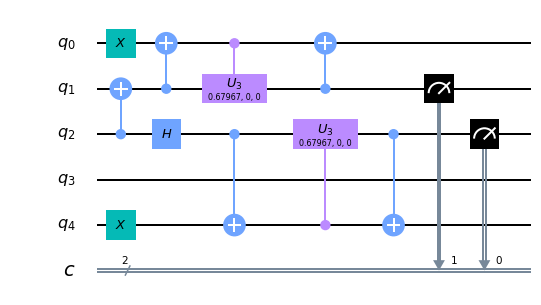

In [5]:
circuits['ZZ_XX']['00'][1].draw(output='mpl')

Drawing of one of the circuit of the composition map, with measurement on the Bell basis. Notice that consecutive gates resulting in identity have been removed.

### 2. Simulation <a id="simulation"/>

This cell executes locally the (noiseless) simulation of the circuits above.

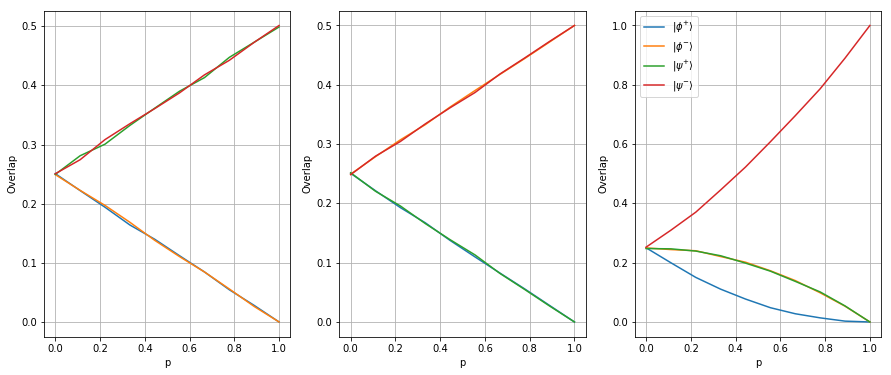

In [6]:
# Execute the circuits on the local simulator
jobs_sim = {}
for pump in pumps:
    jobs_sim[pump] = {}
    for ic in ic_state_labels:
        jobs_sim[pump][ic] = execute(circuits[pump][ic], backend = simulator, shots = SHOTS)

# Analyse the outcomes
overlaps_sim = {}
for pump in pumps:
    overlaps_sim[pump] = {}
    for ic in ic_state_labels:
        overlaps_sim[pump][ic] = [0.0]*len(p_values)
    for i in range(len(p_values)):
        for ic in ic_state_labels:
            counts = jobs_sim[pump][ic].result().get_counts(i)
            for outcome in counts:
                overlaps_sim[pump][outcome][i] += counts[outcome]/(4.0 * float(SHOTS))

# Plot the results
fig_idx = 131
plt.figure(figsize=(15,6))
bell_labels = {'00': r"$| \phi^{+} \rangle$", '01': r"$| \phi^{-} \rangle$", '10': r"$| \psi^{+} \rangle$", '11': r"$| \psi^{-} \rangle$"}
for pump in pumps:
    plt.subplot(fig_idx)
    for outcome in overlaps_sim[pump]:
        plt.plot(p_values, overlaps_sim[pump][outcome], label = bell_labels[outcome])
    plt.xlabel('p')
    plt.ylabel('Overlap')
    fig_idx += 1
    plt.grid()
plt.legend();

### 3. Execution on the real device <a id="execution" />

In [ ]:
# Run the calibration job
calibration_job = execute(cal_circuits, backend, shots=SHOTS)

# Run the circuits and save the jobs
jobs = {}
jobs_data = []
for pump in pumps:
    jobs[pump] = {}
    for ic in ic_state_labels:
        jobs[pump][ic] = execute(circuits[pump][ic], backend = backend, shots = SHOTS)
        job_data = {'jobid': jobs[pump][ic].job_id(),
                   'description': pump+' pump with initial condition '+ic+' for each value of p',
                   'metadata': {'p_values': list(p_values), 'pump': pump, 'initial_condition': ic}}
        jobs_data.append(job_data)

experiment_data = [{
    "backend": backend.name(),
    "calibration": calibration_job.job_id(),
    "description": "Circuits for the simulation of the reservoir engineering channels",
    "jobs": jobs_data
    }]

filename = 'reservoir_engineering_{}.json'.format(
            datetime.now().strftime(("%Y_%m_%d-%H_%M")))

with open(filename,'w') as file:
    json.dump(experiment_data, file)

All the information about the experiment is stored in a JSON file called `reservoir_engineering_DATETIME.json`.

### 4. Analysis of the results <a id="analysis"/>
#### Instructions:
Use the `filename` variable to load the JSON file containing the experiment information

In [7]:
# List the available experiment files
import glob

print("Available experiment files:")
for f in glob.glob('*.json'):
    print(f)

Available experiment files:
reservoir_engineering_2019_11_13-15_54.json


In [8]:
# Load the experiment file
filename = "reservoir_engineering_2019_11_13-15_54.json"

with open(filename, 'r') as file:
    experiment_data = json.load(file)
print(experiment_data[0]['description'])
print("Run on", experiment_data[0]['backend'])

Circuits for the simulation of the reservoir engineering channels
Run on ibmqx2


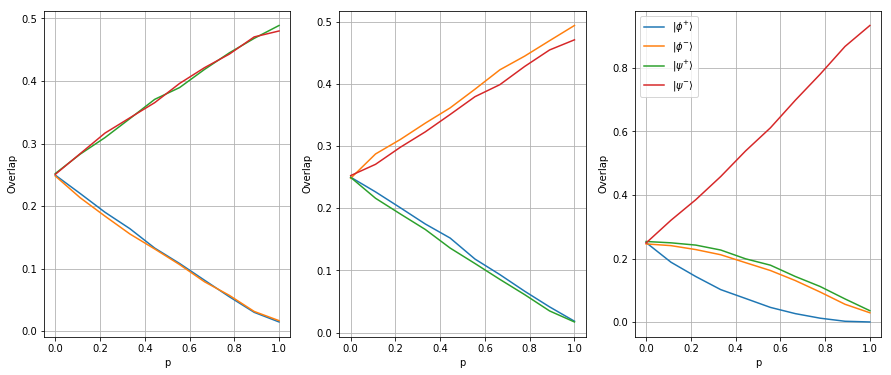

In [9]:
# Get the backend
backend = IBMQ.get_provider(hub='ibm-q', group='open', project='main').get_backend(experiment_data[0]['backend'])

# Use the calibration job to implement the error mitigation
calibration_job = backend.retrieve_job(experiment_data[0]['calibration'])
meas_fitter = CompleteMeasFitter(calibration_job.result(), ic_state_labels)
meas_filter = meas_fitter.filter

# Analyse the outcomes
p_values = np.array(experiment_data[0]['jobs'][0]['metadata']['p_values'])

jobs = {}
for job in experiment_data[0]['jobs']:
    pump = job['metadata']['pump']
    ic = job['metadata']['initial_condition']
    if pump not in jobs:
        jobs[pump] = {}
    jobs[pump][ic] = backend.retrieve_job(job['jobid'])

overlaps = {}
for pump in pumps:
    overlaps[pump] = {}
    for ic in ic_state_labels:
        overlaps[pump][ic] = [0.0]*len(p_values)
    for i in range(len(p_values)):
        for ic in ic_state_labels:
            counts = meas_filter.apply(jobs[pump][ic].result()).get_counts(i)
            for outcome in counts:
                overlaps[pump][outcome][i] += counts[outcome]/(4 * float(SHOTS))

# Plot the results
fig_idx = 131
plt.figure(figsize=(15,6))
bell_labels = {'00': r"$| \phi^{+} \rangle$", '01': r"$| \phi^{-} \rangle$", '10': r"$| \psi^{+} \rangle$", '11': r"$| \psi^{-} \rangle$"}
for pump in pumps:
    plt.subplot(fig_idx)
    for outcome in overlaps[pump]:
        plt.plot(p_values, overlaps[pump][outcome], label = bell_labels[outcome])
    plt.xlabel('p')
    plt.ylabel('Overlap')
    fig_idx += 1
    plt.grid()
plt.legend();

The job contains info on the gate and measurement error rates

In [10]:
jobs['ZZ']['00'].properties().qubits

[[Nduv(date=datetime.datetime(2019, 11, 13, 9, 53, 59, tzinfo=tzutc()), name='T1', unit='µs', value=68.59173461377988),
  Nduv(date=datetime.datetime(2019, 11, 13, 9, 54, 25, tzinfo=tzutc()), name='T2', unit='µs', value=61.42847822569171),
  Nduv(date=datetime.datetime(2019, 11, 13, 11, 4, 47, tzinfo=tzutc()), name='frequency', unit='GHz', value=5.286280461378225),
  Nduv(date=datetime.datetime(2019, 11, 13, 9, 49, 29, tzinfo=tzutc()), name='readout_error', unit='', value=0.013000000000000012),
  Nduv(date=datetime.datetime(2019, 11, 13, 9, 49, 29, tzinfo=tzutc()), name='prob_meas0_prep1', unit='', value=0.019000000000000017),
  Nduv(date=datetime.datetime(2019, 11, 13, 9, 49, 29, tzinfo=tzutc()), name='prob_meas1_prep0', unit='', value=0.007)],
 [Nduv(date=datetime.datetime(2019, 11, 11, 9, 22, 5, tzinfo=tzutc()), name='T1', unit='µs', value=48.43983536027821),
  Nduv(date=datetime.datetime(2019, 11, 13, 9, 55, 35, tzinfo=tzutc()), name='T2', unit='µs', value=41.25323017602444),
  Ndu

In [11]:
jobs['ZZ']['00'].properties().gates

[Gate(gate='id', name='id_0', parameters=[Nduv(date=datetime.datetime(2019, 11, 13, 10, 1, 14, tzinfo=tzutc()), name='gate_error', unit='', value=0.0004920536628101479), Nduv(date=datetime.datetime(2019, 11, 13, 11, 4, 47, tzinfo=tzutc()), name='gate_length', unit='ns', value=35.55555555555556)], qubits=[0]),
 Gate(gate='u1', name='u1_0', parameters=[Nduv(date=datetime.datetime(2019, 11, 13, 10, 1, 14, tzinfo=tzutc()), name='gate_error', unit='', value=0.0), Nduv(date=datetime.datetime(2019, 11, 13, 11, 4, 47, tzinfo=tzutc()), name='gate_length', unit='ns', value=0.0)], qubits=[0]),
 Gate(gate='u2', name='u2_0', parameters=[Nduv(date=datetime.datetime(2019, 11, 13, 10, 1, 14, tzinfo=tzutc()), name='gate_error', unit='', value=0.0004920536628101479), Nduv(date=datetime.datetime(2019, 11, 13, 11, 4, 47, tzinfo=tzutc()), name='gate_length', unit='ns', value=35.55555555555556)], qubits=[0]),
 Gate(gate='u3', name='u3_0', parameters=[Nduv(date=datetime.datetime(2019, 11, 13, 10, 1, 14, tzin